- Показать callbacks, tensor board

#  Давайте посмотрим теперь на Keras


но так как мы ленивые, то давайте использовать все тот же fashion mnist

In [22]:
!pip install torchvision

    100% |████████████████████████████████| 61kB 5.0MB/s 
    100% |████████████████████████████████| 2.0MB 14.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


Минимальные импорты

In [0]:
import numpy as np
import tensorflow as tf
import os
from torchvision.datasets import mnist


Подргужаем Fashion Mnist

In [24]:
# Create random input and output data
def toNumpy(x):
    return np.array(x,np.float32).flatten()/255.0


def label(label):
        r=np.zeros(10,np.float32);
        r[label]=1.0;
        return r;
tr=mnist.FashionMNIST(os.path.curdir+"/fmnist",download=True,transform=toNumpy,target_transform=label,train=True)
val=mnist.FashionMNIST(os.path.curdir+"/fmnist",download=True,transform=toNumpy,target_transform=label,train=False)



Processing...
Done!


Делаем генератор данных

In [0]:
BATCH_SIZE=16
def gen(data):
    while True:
        x_b=[]
        y_b=[]
        for i_batch, sample_batched in enumerate(data):
            # Forward pass: compute predicted y
            x = sample_batched[0]
            y = sample_batched[1]
            x_b.append(x)
            y_b.append(y)
            if len(x_b)==BATCH_SIZE:
                yield np.array(x_b),np.array(y_b)
                x_b=[]
                y_b=[]

Импортируем не обходимый минимум из Keras

In [0]:
from keras.layers.core import Dense
import keras.optimizers as opt
import keras.models as models

Определяем модельку и быстренько ее обучаем

In [27]:
m=models.Sequential()
m.add(Dense(10,input_dim=784,activation="relu"))
m.add(Dense(10,activation=None))
m.compile(opt.Adam(),loss="mse",metrics=["binary_accuracy"])
m.fit_generator(gen(tr),len(tr),epochs=10,verbose=1,validation_data=gen(val),validation_steps=len(val))

Epoch 1/10
  518/60000 [..............................] - ETA: 14:03 - loss: 0.0874 - binary_accuracy: 0.9031

KeyboardInterrupt: ignored

Всего 5 строчек , не правда ли несколько компактнеее чем на питорч

# А давайте теперь сделаем свой слой.

In [0]:

from keras import backend as K
from keras.engine.topology import Layer

In [0]:
class MyDense(Layer):

    def __init__(self, output_dim, **kwargs):
        self.units = output_dim
        super(MyDense, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        super(MyDense, self).build(input_shape)

    def call(self, x):
        y = K.softmax(K.dot(x, self.kernel))
        return y

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [68]:
m=models.Sequential()
m.add(Dense(10,input_dim=784,activation="relu"))
m.add(MyDense(10))
m.compile(opt.Adam(),loss="binary_crossentropy",metrics=["binary_accuracy"])
m.fit_generator(gen(tr),len(tr)/BATCH_SIZE,epochs=4,verbose=1,validation_data=gen(val),validation_steps=len(val)/BATCH_SIZE)

Epoch 1/4
3750/3750 [==============================] - 28s 8ms/step - loss: 0.1107 - binary_accuracy: 0.9555 - val_loss: 0.0917 - val_binary_accuracy: 0.9639
Epoch 2/4
3750/3750 [==============================] - 28s 7ms/step - loss: 0.0830 - binary_accuracy: 0.9673 - val_loss: 0.0861 - val_binary_accuracy: 0.9666
Epoch 3/4
3750/3750 [==============================] - 28s 7ms/step - loss: 0.0777 - binary_accuracy: 0.9695 - val_loss: 0.0833 - val_binary_accuracy: 0.9674
Epoch 4/4
3750/3750 [==============================] - 28s 7ms/step - loss: 0.0748 - binary_accuracy: 0.9707 - val_loss: 0.0810 - val_binary_accuracy: 0.9683


Окей, давайте посмотрим на какие нить картинки уже.

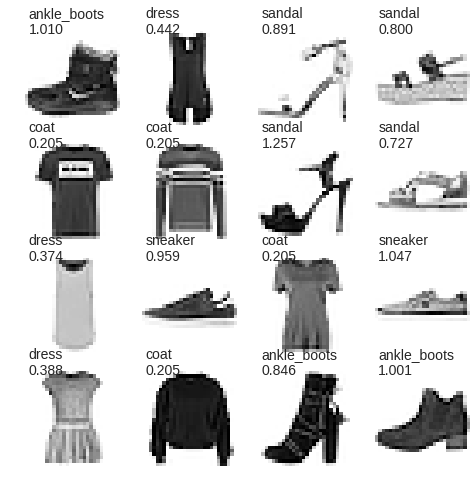

In [45]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
from matplotlib import pyplot
%matplotlib inline
x_test,y_test=gen(tr).__next__()
def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  
imgs=np.squeeze(np.reshape(x_test[:16],(16,28,28,1)))
plot_predictions(imgs, 
                 m.predict(x_test[:16]))

# А что если нам нужно что то более сложное (keras functional api)

In [15]:
from keras.engine import Input
from keras.models import Model
i=Input(shape=(784,))
m=Dense(10,activation="relu")(i)
m=MyDense(10)(m)
m=Model(i,m)
m.compile(opt.Adam(),loss="binary_crossentropy",metrics=["binary_accuracy"])
m.fit_generator(gen(tr),len(tr)/BATCH_SIZE,epochs=4,verbose=1,validation_data=gen(val),validation_steps=len(val)/BATCH_SIZE)

NameError: ignored

Здесь было бы прикольно расказать про то зачем это нужно, много голов и много выходов, shared weights e.t.c

# Dynamic Graph 

A если Keras такой лаконичный и простой то зачем pytorch?

In [2]:
!pip install torch

    100% |████████████████████████████████| 519.5MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59fb8000 @  0x7ff844dad2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [3]:
import random
import torch

class DynamicNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we construct three nn.Linear instances that we will use
    in the forward pass.
    """
    super(DynamicNet, self).__init__()
    self.input_linear = torch.nn.Linear(D_in, H)
    self.middle_linear = torch.nn.Linear(H, H)
    self.output_linear = torch.nn.Linear(H, D_out)

  def forward(self, x):
    """
    For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
    and reuse the middle_linear Module that many times to compute hidden layer
    representations.

    Since each forward pass builds a dynamic computation graph, we can use normal
    Python control-flow operators like loops or conditional statements when
    defining the forward pass of the model.

    Here we also see that it is perfectly safe to reuse the same Module many
    times when defining a computational graph. This is a big improvement from Lua
    Torch, where each Module could be used only once.
    """
    h_relu = self.input_linear(x).clamp(min=0)
    for _ in range(random.randint(0, 3)):
      h_relu = self.middle_linear(h_relu).clamp(min=0)
    y_pred = self.output_linear(h_relu)
    return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = DynamicNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
for t in range(500):
  # Forward pass: Compute predicted y by passing x to the model
  y_pred = model(x)

  # Compute and print loss
  loss = criterion(y_pred, y)
  print(t, loss.item())

  # Zero gradients, perform a backward pass, and update the weights.
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

0 672.0288696289062
1 661.0844116210938
2 660.2791748046875
3 661.6993408203125
4 698.593017578125
5 656.943603515625
6 610.4100952148438
7 632.3618774414062
8 490.77593994140625
9 427.3105773925781
10 653.1910400390625
11 615.9061279296875
12 645.98681640625
13 651.5777587890625
14 222.46640014648438
15 194.16604614257812
16 649.3427734375
17 568.0852661132812
18 116.92906188964844
19 629.1339111328125
20 622.5010986328125
21 611.9189453125
22 637.3998413085938
23 74.44841766357422
24 568.887451171875
25 432.9012756347656
26 403.24237060546875
27 80.37194061279297
28 330.662353515625
29 79.6689682006836
30 262.4812927246094
31 67.75813293457031
32 56.159461975097656
33 511.98138427734375
34 33.52212905883789
35 470.2814636230469
36 23.911218643188477
37 419.3988952636719
38 19.538116455078125
39 131.59848022460938
40 270.4704895019531
41 250.53135681152344
42 226.68540954589844
43 35.74581527709961
44 174.98524475097656
45 224.88006591796875
46 38.498905181884766
47 128.49383544921875

# Callbacks , Tensorboard

In [0]:
import keras
from sklearn.metrics import roc_auc_score

class Histories(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.aucs = []
        self.losses = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        y_pred = self.model.predict(x_test[:16])
        print(np.argmax(y_pred))
        return

    def on_batch_begin(self, batch, logs=None):
        pass

In [38]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2018-10-31 13:22:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.44.144.199, 52.55.191.55, 52.201.75.180, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.44.144.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  7.66MB/s    in 0.7s    

2018-10-31 13:22:39 (7.66 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = '/tmp/log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [41]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://ea75ccf4.ngrok.io


In [50]:
tbc=keras.callbacks.TensorBoard(log_dir='/tmp/log', histogram_freq=0,
                            write_graph=True, write_images=True)
m.fit_generator(gen(tr),len(tr)/BATCH_SIZE,epochs=4,verbose=1,validation_data=gen(val),validation_steps=len(val)/BATCH_SIZE,callbacks=[Histories(),tbc])

Epoch 1/4
3750/3750 [==============================] - 24s 7ms/step - loss: 0.0489 - binary_accuracy: 0.9417 - val_loss: 0.0505 - val_binary_accuracy: 0.9397
95
Epoch 2/4
3750/3750 [==============================] - 25s 7ms/step - loss: 0.0445 - binary_accuracy: 0.9458 - val_loss: 0.0442 - val_binary_accuracy: 0.9451
95
Epoch 3/4
3750/3750 [==============================] - 25s 7ms/step - loss: 0.0423 - binary_accuracy: 0.9476 - val_loss: 0.0440 - val_binary_accuracy: 0.9454
95
Epoch 4/4
3750/3750 [==============================] - 25s 7ms/step - loss: 0.0421 - binary_accuracy: 0.9478 - val_loss: 0.0439 - val_binary_accuracy: 0.9456
95
